In [1]:
! pip install pyreadstat pyarrow matplotlib


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd

Taiwan_QQQ = pd.read_feather('Cleaned_2022_Reading.feather')

# 切割資料集為訓練集和測試集
from sklearn.model_selection import train_test_split
X = Taiwan_QQQ.drop(['Reading_level'], axis=1)
y = Taiwan_QQQ['Reading_level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

mi = mutual_info_classif(X_train, y_train)
mi_scores = pd.Series(mi, index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)  # 降序排序
print(mi_scores[:100])

MATHEFF       0.109154
ICTEFFIC      0.087742
ICTOUT        0.075558
ICTSUBJ       0.071756
ICTREG        0.070648
                ...   
STRESAGR      0.019447
IC176Q01JA    0.019307
EMOCOAGR      0.019233
LANGN         0.019077
IC178Q04JA    0.018741
Length: 100, dtype: float64


In [4]:
selected_column = mi_scores[:100].keys()
X_train = X_train[selected_column]
X_test = X_test[selected_column]

X_train.head()

,MATHEFF,ICTEFFIC,ICTOUT,ICTSUBJ,ICTREG,ICTRES,ST296Q04JA,ST255Q01JA,HOMEPOS,ICTENQ,...,IC178Q07JA,IC170Q05JA,IC173Q01JA,RELATST,PERSEVAGR,STRESAGR,IC176Q01JA,EMOCOAGR,LANGN,IC178Q04JA
116617,-1.5802,-2.6393,-1.8681,-1.0124,0.9085,-0.6491,4.0,2.0,-1.2849,-2.3763,...,2.0,3.0,1.0,0.0155,-0.5249,0.6176,1.0,0.7121,641.0,5.0
113200,-0.0701,1.9551,0.5817,-0.1212,0.8328,0.3435,4.0,7.0,0.7375,0.5375,...,2.0,3.0,2.0,1.1131,2.7704,0.3083,5.0,0.5840,641.0,3.0
114431,-0.2596,1.9495,-0.6846,-1.0124,-1.0564,-1.0447,2.0,1.0,-1.4658,-1.3812,...,1.0,3.0,1.0,-0.8032,-0.4753,0.0757,3.0,0.2397,641.0,1.0
116880,-3.4814,-1.1255,-2.5404,-2.0101,-2.6720,-1.3897,1.0,3.0,-2.0020,-1.3812,...,6.0,1.0,1.0,1.3277,-0.9259,0.0211,1.0,0.5835,641.0,2.0
114548,-3.4257,1.9495,-2.5404,-0.4015,-2.6720,0.2967,1.0,1.0,-0.3491,-1.1017,...,1.0,5.0,3.0,-0.3981,3.0554,0.0210,1.0,0.5368,641.0,6.0


In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svm_pipeline = Pipeline([('scaler', StandardScaler()), ('svm', SVC())])

# 設定參數網格
svm_param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': [0.1, 1, 10]
}


# 創建 GridSearchCV 物件
svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, verbose=4, n_jobs=-1)

# 執行網格搜索
svm_grid_search.fit(X_train, y_train)

# 访问 cv_results_
svm_cv_results = svm_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(svm_cv_results['params'])):
    print("Params:", svm_cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", svm_cv_results[f'split{j}_test_score'][i])

# 最佳參數和模型
print("Best parameters:", svm_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(svm_grid_search.best_score_))

# 使用最佳參數的模型對測試集進行預測
best_model = svm_grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Params: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'linear'}
Fold 1 score: 0.7886872998932765
Fold 2 score: 0.8046958377801494
Fold 3 score: 0.8046958377801494
Fold 4 score: 0.80042689434365
Fold 5 score: 0.7940234791889007
Params: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Fold 1 score: 0.5314834578441836
Fold 2 score: 0.5304162219850587
Fold 3 score: 0.5304162219850587
Fold 4 score: 0.5304162219850587
Fold 5 score: 0.5304162219850587
Params: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'poly'}
Fold 1 score: 0.767342582710779
Fold 2 score: 0.7726787620064034
Fold 3 score: 0.7748132337246532
Fold 4 score: 0.7694770544290288
Fold 5 score: 0.7822838847385272
Params: {'svm__C': 0.1, 'svm__gamma': 1, 'svm__kernel': 'linear'}
Fold 1 score: 0.7886872998932765
Fold 2 score: 0.8046958377801494
Fold 3 score: 0.8046958377801494
Fold 4 score: 0.80042689434365
Fold 5 score: 0.7940234791889007
Params: {'svm__C':

In [6]:
from sklearn.ensemble import RandomForestClassifier

# 設定參數網格
rf_param_grid = {
    'n_estimators': [100, 200, 300],  # 決策樹的數量
    'max_depth': [None, 10, 20, 30],  # 最大深度
    'min_samples_split': [2, 5, 10],  # 每個節點至少包含的數據量，才能繼續分割
    'min_samples_leaf': [1, 2, 4]    # 每個葉子最少的樣本數
}

# 創建 GridSearchCV 物件
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, verbose=2, n_jobs=-1)

# 執行網格搜索
rf_grid_search.fit(X_train, y_train)

# 访问 cv_results_
rf_cv_results = rf_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(rf_cv_results['params'])):
    print("Params:", rf_cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", rf_cv_results[f'split{j}_test_score'][i])

# 最佳參數和模型
print("Best parameters:", rf_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(rf_grid_search.best_score_))

# 使用最佳參數的模型對測試集進行預測
rf_best_model = rf_grid_search.best_estimator_
rf_test_score = rf_best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(rf_test_score))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fold 1 score: 0.7897545357524013
Fold 2 score: 0.8143009605122732
Fold 3 score: 0.8089647812166488
Fold 4 score: 0.8036286019210246
Fold 5 score: 0.7876200640341515
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Fold 1 score: 0.7929562433297759
Fold 2 score: 0.8068303094983992
Fold 3 score: 0.8110992529348986
Fold 4 score: 0.8100320170757738
Fold 5 score: 0.7972251867662753
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Fold 1 score: 0.7961579509071505
Fold 2 score: 0.8121664887940235
Fold 3 score: 0.8110992529348986
Fold 4 score: 0.8132337246531484
Fold 5 score: 0.7982924226254002
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Fold 1 score: 0.7865528281750267
Fold 2 score: 0.812166488

In [7]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# 设置参数网格
xg_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 2, 3]
}


# 创建 GridSearchCV 对象
xg_grid_search = GridSearchCV(xgb_model, xg_param_grid, cv=5, verbose=4, n_jobs=-1)

# 执行网格搜索
xg_grid_search.fit(X_train, y_train)

# 访问 cv_results_
xg_cv_results = xg_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(xg_cv_results['params'])):
    print("Params:", xg_cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", xg_cv_results[f'split{j}_test_score'][i])

# 最佳参数和模型
print("Best parameters:", xg_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(xg_grid_search.best_score_))

# 使用最佳参数的模型对测试集进行预测
xgb_best_model = xg_grid_search.best_estimator_
xgb_test_score = xgb_best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(xgb_test_score))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50}
Fold 1 score: 0.743863393810032
Fold 2 score: 0.7406616862326574
Fold 3 score: 0.7513340448239061
Fold 4 score: 0.7502668089647813
Fold 5 score: 0.7321237993596584
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
Fold 1 score: 0.7556029882604055
Fold 2 score: 0.7641408751334045
Fold 3 score: 0.7620064034151548
Fold 4 score: 0.7726787620064034
Fold 5 score: 0.759871931696905
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
Fold 1 score: 0.7854855923159018
Fold 2 score: 0.7801494130202775
Fold 3 score: 0.7801494130202775
Fold 4 score: 0.8046958377801494
Fold 5 score: 0.768409818569904
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 50}
Fold 1 score: 0.743863393810032
Fold 2 score: 0.7406616862326574
Fold 3 score: 0

In [8]:
from sklearn.linear_model import LogisticRegression

# 设置参数网格
lg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty':  ['l1', 'l2']
}

# 创建 GridSearchCV 对象
lg_grid_search = GridSearchCV(LogisticRegression(solver='saga'), lg_param_grid, cv=5, verbose=2, n_jobs=-1)

# 执行网格搜索
lg_grid_search.fit(X_train, y_train)

# 访问 cv_results_
lg_cv_results = lg_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(lg_cv_results['params'])):
    print("Params:", lg_cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", lg_cv_results[f'split{j}_test_score'][i])

# 最佳参数和模型
print("Best parameters:", lg_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(lg_grid_search.best_score_))

# 使用最佳参数的模型对测试集进行预测
lg_best_model = lg_grid_search.best_estimator_
lg_test_score = lg_best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(lg_test_score))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/ponywen/Documents/projects/DataSciFinal/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/projects/DataSciFinal/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/projects/DataSciFinal/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/projects/DataSciFinal/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/projects/DataSciFinal/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

Params: {'C': 0.01, 'penalty': 'l1'}
Fold 1 score: 0.7652081109925294
Fold 2 score: 0.7694770544290288
Fold 3 score: 0.7652081109925294
Fold 4 score: 0.7502668089647813
Fold 5 score: 0.7641408751334045
Params: {'C': 0.01, 'penalty': 'l2'}
Fold 1 score: 0.7705442902881536
Fold 2 score: 0.7822838847385272
Fold 3 score: 0.7737459978655283
Fold 4 score: 0.7545357524012807
Fold 5 score: 0.767342582710779
Params: {'C': 0.1, 'penalty': 'l1'}
Fold 1 score: 0.7737459978655283
Fold 2 score: 0.7812166488794023
Fold 3 score: 0.7748132337246532
Fold 4 score: 0.7534685165421559
Fold 5 score: 0.7662753468516542
Params: {'C': 0.1, 'penalty': 'l2'}
Fold 1 score: 0.7705442902881536
Fold 2 score: 0.7822838847385272
Fold 3 score: 0.7748132337246532
Fold 4 score: 0.7545357524012807
Fold 5 score: 0.768409818569904
Params: {'C': 1, 'penalty': 'l1'}
Fold 1 score: 0.7705442902881536
Fold 2 score: 0.7822838847385272
Fold 3 score: 0.7737459978655283
Fold 4 score: 0.7513340448239061
Fold 5 score: 0.76734258271077

/Users/ponywen/Documents/projects/DataSciFinal/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [9]:
import shap
import xgboost as xgb
from sklearn.model_selection import KFold
# {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 200}
# classifier = xgb.XGBClassifier(n_estimators=200,min_child_weight=3,max_depth=5, learning_rate=0.1)
xgb_best_model.score(X_test, y_test)

0.8071672354948806

In [10]:
explainer = shap.Explainer(xgb_best_model)
shap_values = explainer(X_test)

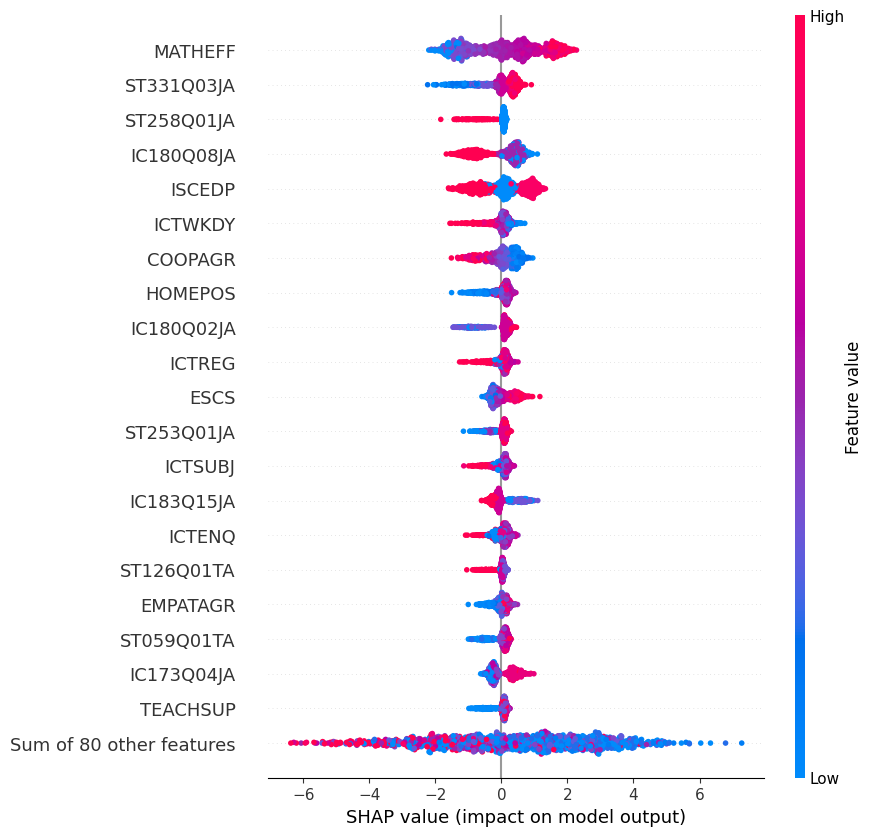

In [11]:
shap.plots.beeswarm(shap_values,max_display=21,order=shap_values.abs.max(0))

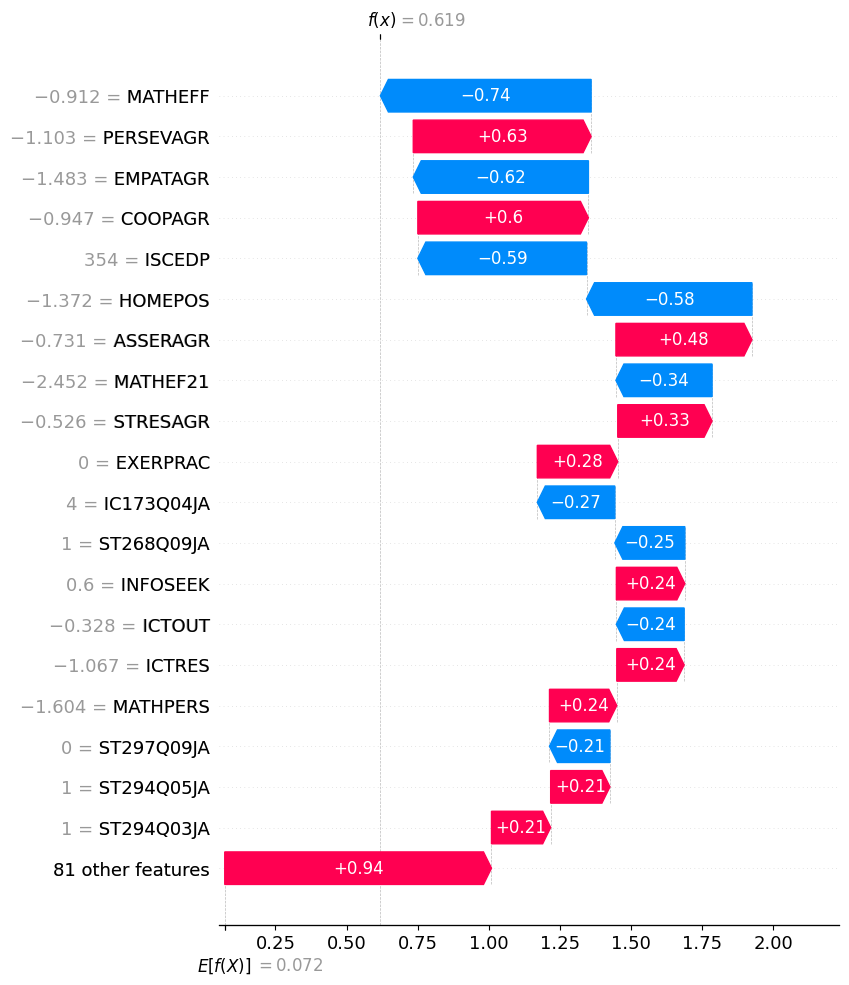

In [12]:
shap.plots.waterfall(shap_values[1], max_display=20)

/var/folders/25/jhs2gh7j0m38835v27rbzg180000gn/T/ipykernel_2693/2010625431.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(values, labels=labels, patch_artist=True, showfliers=False)


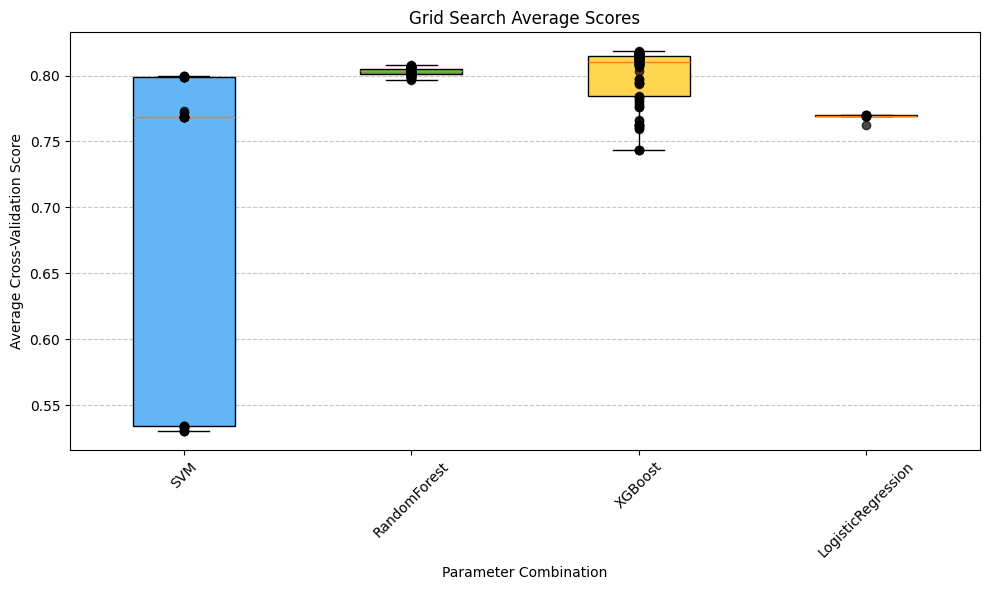

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Labels for the plot
labels = ["SVM", "RandomForest", "XGBoost", "LogisticRegression"]

values = [
    svm_cv_results['mean_test_score'].tolist(),
    rf_cv_results['mean_test_score'].tolist(),
    xg_cv_results['mean_test_score'].tolist(),
    lg_grid_search.cv_results_['mean_test_score'].tolist()
]

# Plotting
plt.figure(figsize=(10, 6))
colors = ['#64B5F6', '#4CAF50', '#FFD54F', '#A1887F']
box = plt.boxplot(values, labels=labels, patch_artist=True, showfliers=False)
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

for i, l in enumerate(labels):
    plt.scatter([i + 1 for _ in values[i]], values[i], color='#000000', alpha=0.7, zorder=3, label=l)
plt.xlabel('Parameter Combination')
plt.ylabel('Average Cross-Validation Score')
plt.title('Grid Search Average Scores')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()